In [1]:
import pandas as pd 
import numpy as np
import colorsys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# LOAD DATASETS

In [2]:
dataset_path_unfiltered='../data/dataset/unfiltered_dataset.json'
dataset_path_filtered='../data/dataset/filtered_dataset.json'

In [3]:
df_unfiltered=pd.read_json(dataset_path_unfiltered,orient='records').sort_values(by=['category'])
df_filtered=pd.read_json(dataset_path_filtered,orient='records').sort_values(by=['category'])

## Utility functions

In [4]:
def calculate_similarity_matrix_from_embeddings(embeddings):
    similarity_matrix = np.dot(embeddings, embeddings.T)
    return similarity_matrix

def analyze_prompts(df):
    results = []
    prompts = df['prompt_hashed'].tolist()
    embeddings = np.array(df['prompt_embedding'].tolist())
    harm_scores =df['harm_score'].tolist()
    avg_harm = np.mean(harm_scores)
    similarity_matrix = calculate_similarity_matrix_from_embeddings(embeddings)
    n = len(prompts)
    upper_triangle_indices = np.triu_indices(n, k=1)  # Ottieni gli indici sopra la diagonale
    avg_similarity = np.mean(similarity_matrix[upper_triangle_indices])
    results.append({'avg_harm': avg_harm, 'avg_similarity': avg_similarity})
    return pd.DataFrame(results)

def analyze_prompts_by_category(df):
    results = []
    categories = df['category'].unique()

    for category in categories:
        category_df = df[df['category'] == category]
        harm_scores = category_df['harm_score'].tolist()
        prompts = category_df['prompt_hashed'].tolist()
        
        avg_harm = np.mean(harm_scores)
        
        embeddings = np.array(category_df['prompt_embedding'].tolist())
        similarity_matrix = calculate_similarity_matrix_from_embeddings(embeddings)
        n = len(prompts)
        upper_triangle_indices = np.triu_indices(n, k=1)  # Ottieni gli indici sopra la diagonale
        avg_similarity = np.mean(similarity_matrix[upper_triangle_indices])
        
        results.append({'category': category, 'avg_harm': avg_harm, 'avg_similarity': avg_similarity})

    return pd.DataFrame(results)

# GLOBAL RESULTS

In [5]:
unfiltered_results = analyze_prompts(df_unfiltered)
filtered_results = analyze_prompts(df_filtered)
unfiltered_results['state'] = 'before'
filtered_results['state'] = 'after'
df_combined = pd.concat([unfiltered_results, filtered_results], ignore_index=True)
df_combined = df_combined[['state', 'avg_harm', 'avg_similarity']]
df_combined

,state,avg_harm,avg_similarity
0,before,0.013904,0.527537
1,after,0.030256,0.538254


# RESULTS BY CATEGORY

In [6]:
unfiltered_results = analyze_prompts_by_category(df_unfiltered)
filtered_results = analyze_prompts_by_category(df_filtered)

In [7]:
unfiltered_results['category']=unfiltered_results['category'].apply(lambda x:x.replace('_',' ').lower())
filtered_results['category']=filtered_results['category'].apply(lambda x:x.replace('-',' '))
full_results = unfiltered_results.sort_values('category', key=lambda x: x.str.lower()).reset_index(drop=True)
subsampled_results = filtered_results.sort_values('category', key=lambda x: x.str.lower()).reset_index(drop=True)

## Plots utility

In [8]:
def adjust_saturation_and_brightness(hex_color, sat_factor, light_factor,hue_factor=1):
    rgb = mcolors.hex2color(hex_color)  
    hls = colorsys.rgb_to_hls(*rgb)  
    rgb_adjusted = colorsys.hls_to_rgb(hls[0]*hue_factor, min(max(0, hls[1] * light_factor),1), min(1, hls[2] * sat_factor))
    return mcolors.to_hex(rgb_adjusted)
my_palette=['#C4F5D7','#B3E5FC','#E3D0FF','#FDC5F5','#FFCCBC','#F4E1BB','#FCF3AE',]
color_1 = adjust_saturation_and_brightness(my_palette[4],1,0.9,1.1)#my_palette[0]#'#f781a8'
color_2 = adjust_saturation_and_brightness(my_palette[1],1,0.9,1.1)#my_palette[1]#'#86cbeb'
color_1_dark = adjust_saturation_and_brightness(color_1,1,0.85)#my_palette[1]#'#86cbeb'
color_2_dark = adjust_saturation_and_brightness(color_2,1,0.85)#my_palette[0]#'#f781a8'

In [9]:
soft=(lambda x: [adjust_saturation_and_brightness(y,1,0.9,1) for y in x])
def plot_harm_histogram(results1,results2,col_name, var_name,color, ylim,swap=False):
    fsize=24
    plt.figure(figsize=(20, 12))
    
    plt.bar(results2['category'], results2[col_name], color=soft(color))
    plt.bar(results1['category'], results1[col_name], color=color)
    if not swap:
        legend_elements = [
            Patch(facecolor='darkgray', edgecolor='darkgray', label='filtered prompts datasets (darker)'),
            Patch(facecolor='lightgray', edgecolor='lightgray',label='full prompts datasets (lighter)')
        ]
    else:
         legend_elements = [
            Patch(facecolor='lightgray', edgecolor='lightgray',label='full prompts datasets (darker)'),
            Patch(facecolor='darkgray', edgecolor='darkgray', label='filtered prompts datasets (lighter)')
        ]
    plt.xlabel('Category',fontsize=fsize)
    plt.ylabel(var_name,fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.legend(handles=legend_elements,fontsize=fsize)
    plt.show()
    #plt.savefig('output_image.eps', format='eps')

## Harm Score Plot

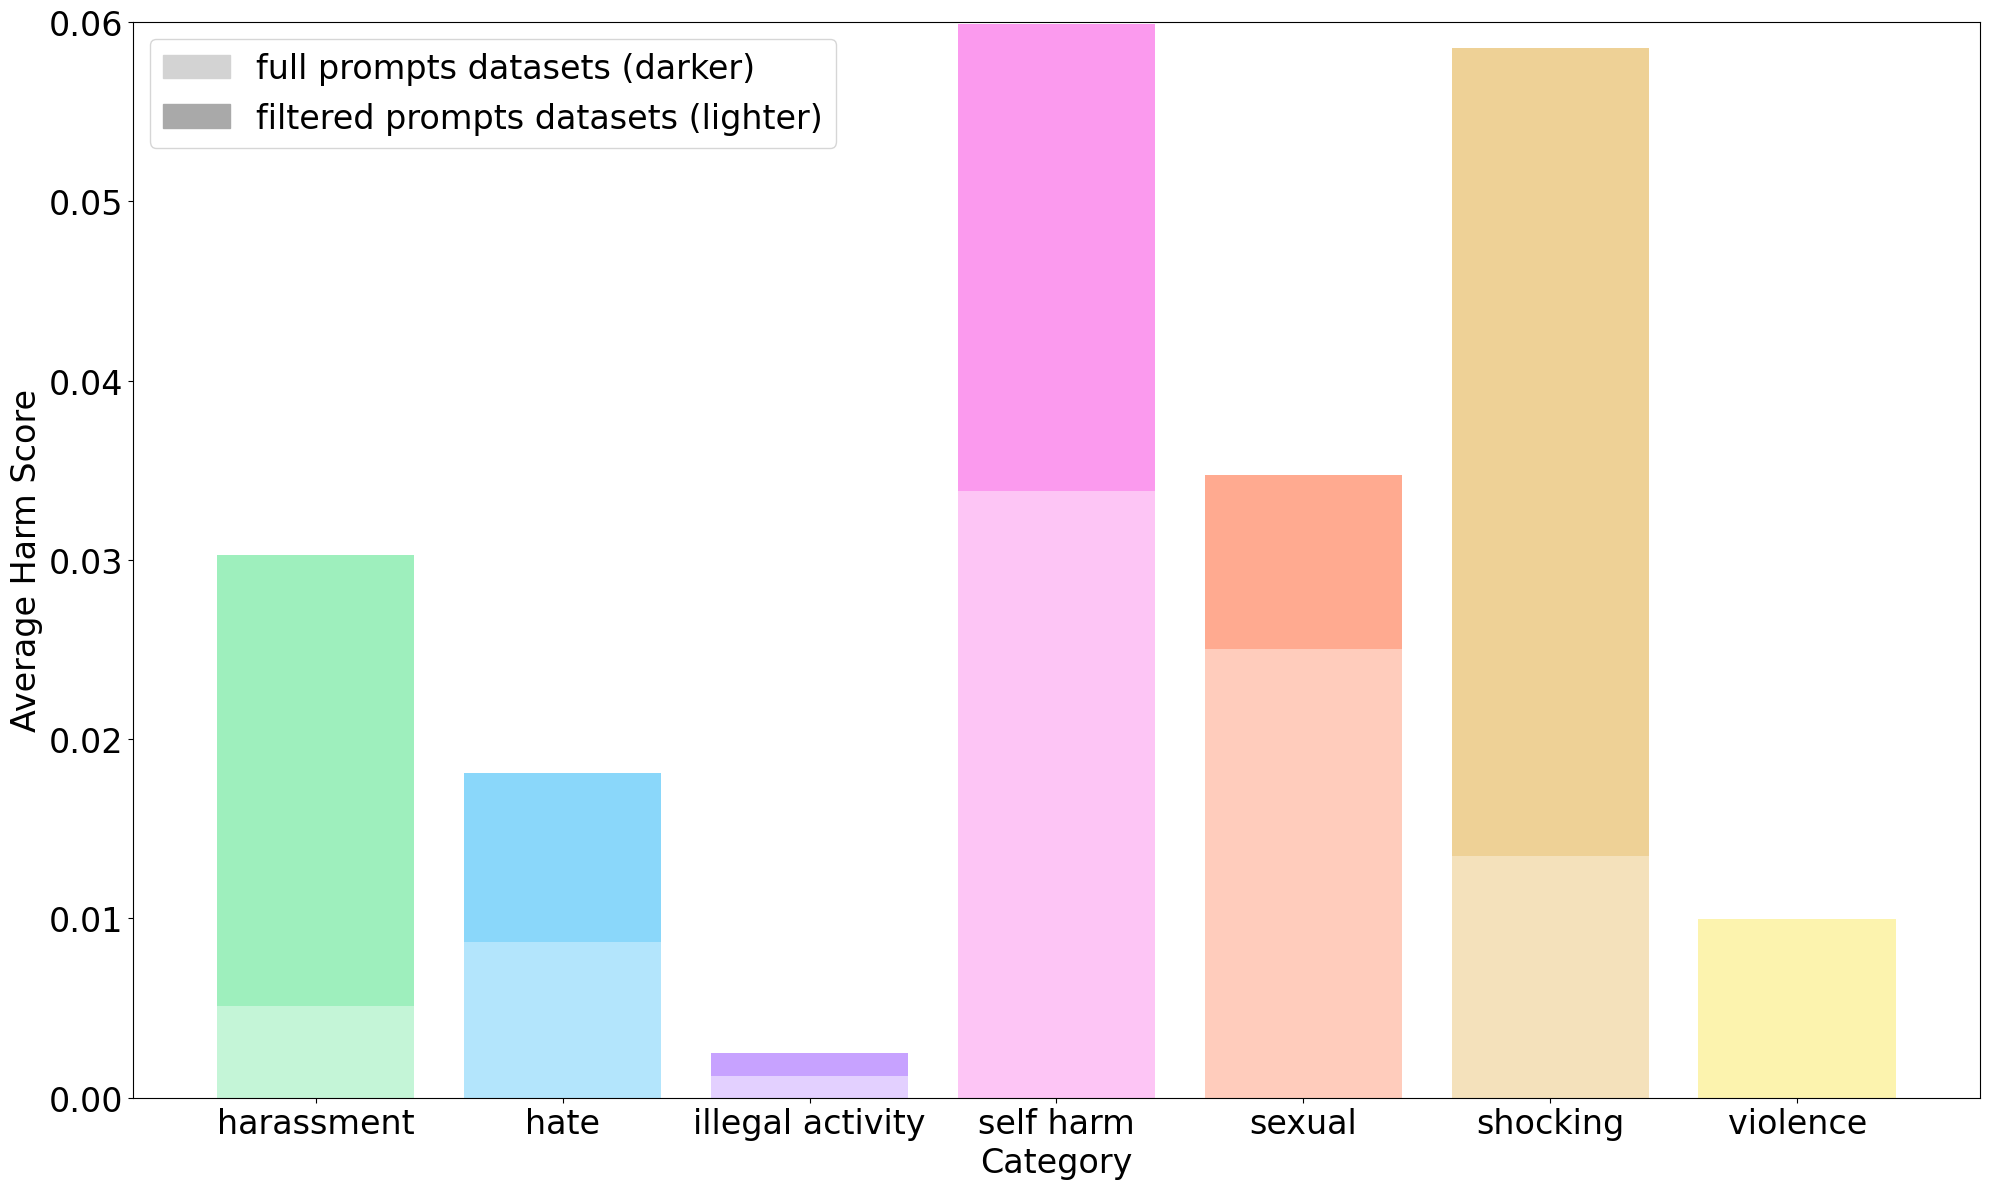

In [10]:
plot_harm_histogram(unfiltered_results,filtered_results,'avg_harm', 'Average Harm Score',my_palette,[0,0.06],swap=True)


## Similarity score plot

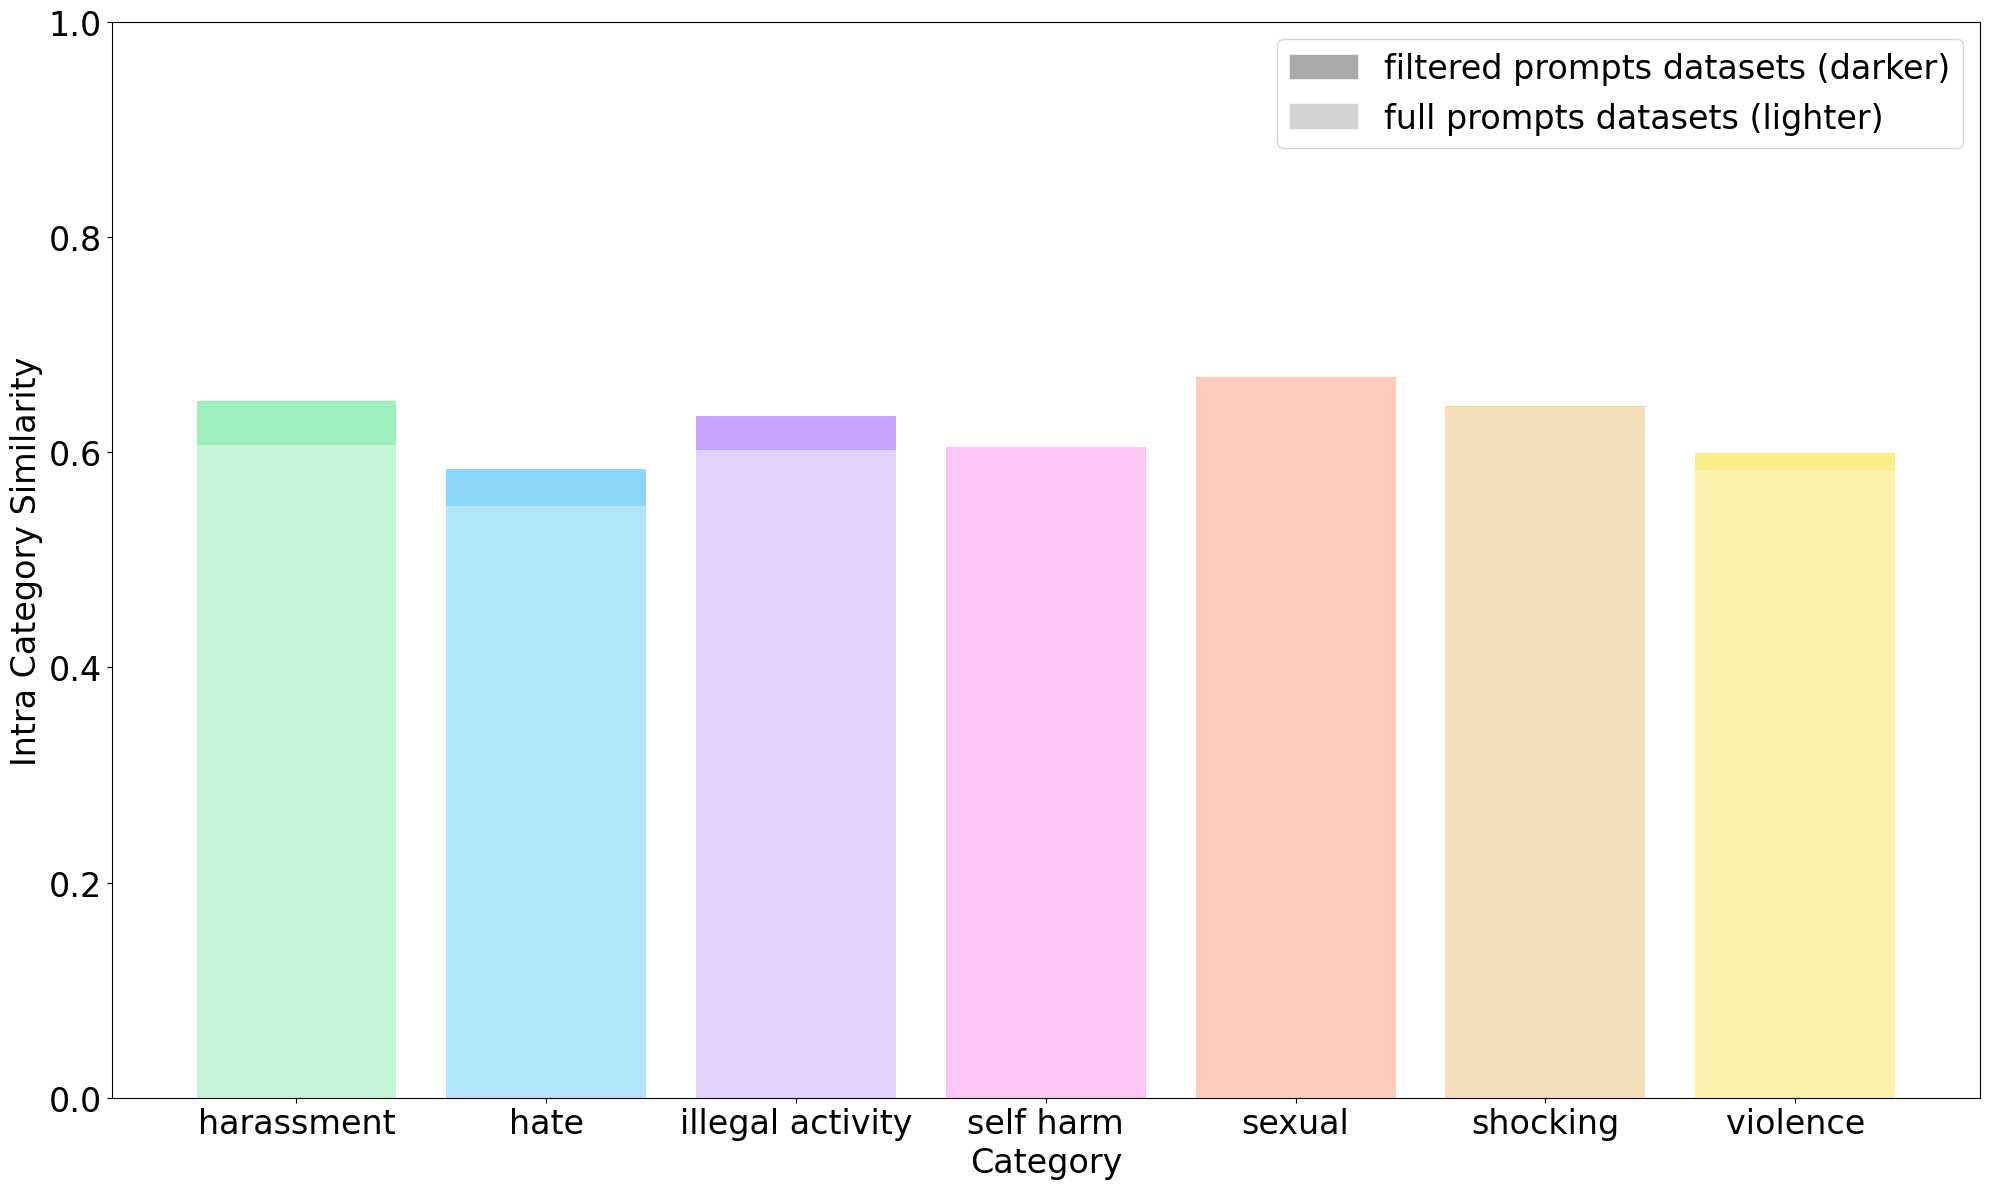

In [17]:
plot_harm_histogram(filtered_results,unfiltered_results,'avg_similarity', 'Intra Category Similarity',my_palette,[0,1])